In [180]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

#### Preprocessing

In [214]:
data_path = '/Users/rheajaisinghani/Desktop/Project DS/Dexcom Data/'

csv_files = glob.glob(data_path + '*.csv')

df_list = []

for file in csv_files:
    df = pd.read_csv(file, skiprows=range(1, 11))
    df_list.append(df)

dexcom_df = pd.concat(df_list, ignore_index=True)

dexcom_df.shape

(314846, 14)

In [182]:
timeseries_data = dexcom_df[['Glucose Value (mg/dL)']]

In [215]:
dexcom_df.loc[dexcom_df['Glucose Value (mg/dL)'] == 'Low', 'Glucose Value (mg/dL)'] = 39
dexcom_df.loc[dexcom_df['Glucose Value (mg/dL)'] == 'High', 'Glucose Value (mg/dL)'] = 401

In [216]:
dexcom_df['Glucose Value (mg/dL)'] = dexcom_df['Glucose Value (mg/dL)'].astype(int)

In [217]:
dexcom_df['Timestamp'] = pd.to_datetime(dexcom_df['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [218]:
# Data was weird for these dates. Multiple records for same time points.
dates_to_remove = ['2023-11-21', '2024-02-14', '2024-08-07']
dates_to_remove = [pd.to_datetime(date).date() for date in dates_to_remove]
dexcom_df = dexcom_df[~dexcom_df['Timestamp'].dt.date.isin(dates_to_remove)]

#### Weeks

In [219]:
# Group by week using pd.Grouper
weekly_counts = dexcom_df.groupby(pd.Grouper(key='Timestamp', freq='W')).size()

count_distribution_week = weekly_counts.value_counts().sort_index()

print("Number of readings per day: Number of days with that many readings")
print("-----------------------------------------------------------")
for readings, weeks in count_distribution_week.items():
    print(f"{readings} readings: {weeks} weeks")

Number of readings per day: Number of days with that many readings
-----------------------------------------------------------
0 readings: 11 weeks
158 readings: 1 weeks
320 readings: 2 weeks
417 readings: 1 weeks
542 readings: 1 weeks
659 readings: 1 weeks
675 readings: 1 weeks
814 readings: 1 weeks
823 readings: 1 weeks
919 readings: 1 weeks
1108 readings: 1 weeks
1225 readings: 1 weeks
1254 readings: 1 weeks
1405 readings: 1 weeks
1431 readings: 1 weeks
1442 readings: 1 weeks
1511 readings: 1 weeks
1528 readings: 1 weeks
1557 readings: 1 weeks
1569 readings: 1 weeks
1587 readings: 1 weeks
1600 readings: 1 weeks
1619 readings: 1 weeks
1664 readings: 1 weeks
1665 readings: 1 weeks
1675 readings: 1 weeks
1696 readings: 1 weeks
1699 readings: 1 weeks
1704 readings: 1 weeks
1712 readings: 1 weeks
1714 readings: 1 weeks
1737 readings: 1 weeks
1788 readings: 1 weeks
1813 readings: 1 weeks
1815 readings: 1 weeks
1817 readings: 1 weeks
1823 readings: 1 weeks
1837 readings: 1 weeks
1838 readi

In [220]:
dexcom_df['week_end'] = dexcom_df['Timestamp'].dt.to_period('W').apply(lambda r: r.end_time)

weekly_counts = dexcom_df.groupby('week_end').size()
print(weekly_counts)


week_end
2021-09-05 23:59:59.999999999     675
2021-09-12 23:59:59.999999999    1983
2021-09-19 23:59:59.999999999    1986
2021-09-26 23:59:59.999999999     814
2021-10-03 23:59:59.999999999    2016
                                 ... 
2025-02-02 23:59:59.999999999    1914
2025-02-09 23:59:59.999999999    1992
2025-02-16 23:59:59.999999999    1885
2025-02-23 23:59:59.999999999    2016
2025-03-02 23:59:59.999999999    1968
Length: 172, dtype: int64


In [221]:
low_count_weeks = weekly_counts[weekly_counts < 1700].index

In [222]:
dexcom_df_week = dexcom_df[~dexcom_df['week_end'].isin(low_count_weeks)]

In [223]:
weekly_groups = dexcom_df_week.groupby(pd.Grouper(key='Timestamp', freq='W'))

weekly_series = [group['Glucose Value (mg/dL)'].values
                 for _, group in weekly_groups if not group.empty]

In [225]:
max_length = max(len(series) for series in weekly_series)

padded_series = []
for series in weekly_series:
    padded = np.pad(series, (0, max_length - len(series)), mode='edge')
    padded_series.append(padded)

data_array = np.array(padded_series)
data_array = data_array[..., np.newaxis]  # Add a feature dimension

print("Shape of data_array:", data_array.shape)

Shape of data_array: (144, 2028, 1)


In [226]:
normalized_data_week = []
scaler = MinMaxScaler()
for series in data_array:
    normalized_series = scaler.fit_transform(series)
    normalized_data_week.append(normalized_series)
normalized_data_week = np.array(normalized_data_week)

Clusters: 2, Silhouette Score: 0.119361746562399
Clusters: 3, Silhouette Score: 0.07189924353661697
Clusters: 4, Silhouette Score: 0.018235463407992425
Clusters: 5, Silhouette Score: 0.007313531149183598


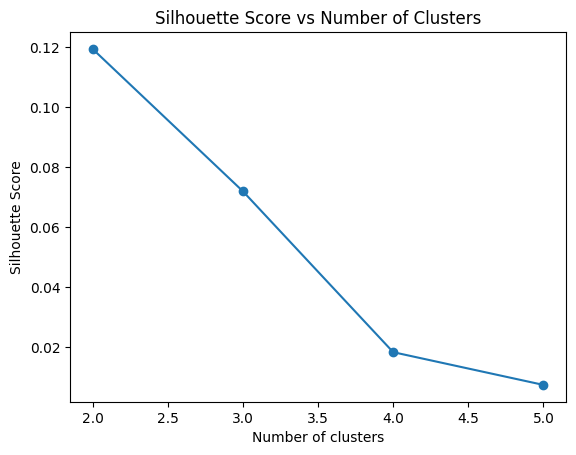

In [229]:
distance_matrix = cdist_dtw(normalized_data_week)

silhouette_scores = []
n_clusters_range = range(2, 6)

for n_clusters in n_clusters_range:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    clusters = kmeans.fit_predict(normalized_data_week)
    
    score = silhouette_score(distance_matrix, clusters, metric="precomputed")
    silhouette_scores.append(score)
    print(f'Clusters: {n_clusters}, Silhouette Score: {score}')

plt.plot(list(n_clusters_range), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


#### Days

In [233]:
daily_counts = dexcom_df.groupby(pd.Grouper(key='Timestamp', freq='D')).size()

In [234]:
count_distribution = daily_counts.value_counts().sort_index()

print("Number of readings per day: Number of days with that many readings")
print("-----------------------------------------------------------")
for readings, days in count_distribution.items():
    print(f"{readings} readings: {days} days")


Number of readings per day: Number of days with that many readings
-----------------------------------------------------------
0 readings: 136 days
2 readings: 1 days
3 readings: 1 days
17 readings: 1 days
32 readings: 2 days
60 readings: 1 days
71 readings: 1 days
76 readings: 1 days
82 readings: 1 days
87 readings: 1 days
91 readings: 1 days
95 readings: 2 days
102 readings: 1 days
103 readings: 1 days
106 readings: 1 days
109 readings: 1 days
117 readings: 1 days
120 readings: 1 days
121 readings: 1 days
124 readings: 1 days
128 readings: 1 days
129 readings: 1 days
130 readings: 1 days
131 readings: 1 days
143 readings: 2 days
147 readings: 2 days
150 readings: 1 days
151 readings: 1 days
154 readings: 2 days
155 readings: 2 days
158 readings: 1 days
159 readings: 1 days
161 readings: 1 days
162 readings: 2 days
165 readings: 1 days
174 readings: 1 days
182 readings: 1 days
184 readings: 1 days
186 readings: 1 days
188 readings: 2 days
190 readings: 1 days
194 readings: 1 days
198 

In [235]:
low_count_days = daily_counts[daily_counts < 200].index
dexcom_df_day = dexcom_df[~dexcom_df['Timestamp'].dt.date.isin(low_count_days)]

In [236]:
daily_groups = dexcom_df_day.groupby(pd.Grouper(key='Timestamp', freq='D'))

daily_series = [group['Glucose Value (mg/dL)'].values
                for _, group in daily_groups if not group.empty]

max_length = max(len(series) for series in daily_series)
padded_series = []
for series in daily_series:
    padded = np.pad(series, (0, max_length - len(series)), mode='edge')
    padded_series.append(padded)

data_array = np.array(padded_series)
data_array = data_array[..., np.newaxis]  # Add a feature dimension

print("Shape of data_array:", data_array.shape)
print("1144 days, 578 glucose values, 1 feature (time series thing)")

# Normalize the data
normalized_data_day = []
scaler = MinMaxScaler()
for series in data_array:
    normalized_series = scaler.fit_transform(series)
    normalized_data_day.append(normalized_series)
normalized_data_day = np.array(normalized_data_day)


Shape of data_array: (1141, 300, 1)
1144 days, 578 glucose values, 1 feature (time series thing)


Clusters: 2, Silhouette Score: 0.21814427332459269
Clusters: 3, Silhouette Score: 0.19565800483947757
Clusters: 4, Silhouette Score: 0.1578311194115137
Clusters: 5, Silhouette Score: 0.14155905588003845


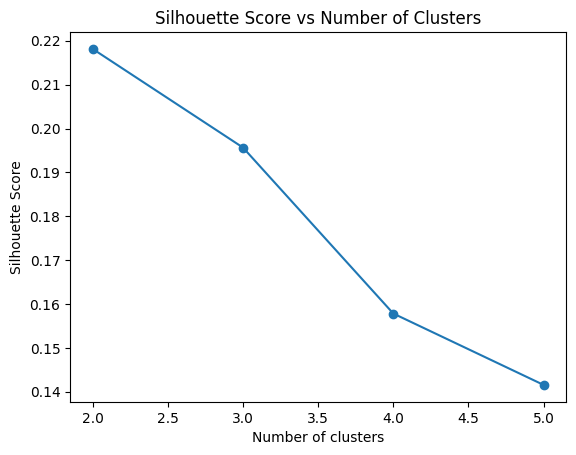

In [237]:
distance_matrix_day = cdist_dtw(normalized_data_day)

silhouette_scores = []
n_clusters_range = range(2, 6)

for n_clusters in n_clusters_range:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    clusters = kmeans.fit_predict(normalized_data_day)

    score = silhouette_score(distance_matrix_day, clusters, metric="precomputed")
    silhouette_scores.append(score)
    print(f'Clusters: {n_clusters}, Silhouette Score: {score}')

plt.plot(list(n_clusters_range), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

#### Hours

In [244]:
hourly_counts = dexcom_df.groupby([dexcom_df['Timestamp'].dt.date, 
                                   dexcom_df['Timestamp'].dt.hour]).size()

low_count_hours = hourly_counts[hourly_counts < 12].index

dexcom_df['date_hour'] = list(zip(dexcom_df['Timestamp'].dt.date, dexcom_df['Timestamp'].dt.hour))

dexcom_df_hours = dexcom_df[~dexcom_df['date_hour'].isin(low_count_hours)]

In [245]:
hourly_groups = dexcom_df_hours.groupby([dexcom_df['Timestamp'].dt.date, 
                                   dexcom_df['Timestamp'].dt.hour])

hourly_series = [group['Glucose Value (mg/dL)'].values
                for _, group in hourly_groups if not group.empty]

max_length = max(len(series) for series in hourly_series)
padded_series = []
for series in hourly_series:
    padded = np.pad(series, (0, max_length - len(series)), mode='edge')
    padded_series.append(padded)

data_array = np.array(padded_series)
data_array = data_array[..., np.newaxis]  # Add a feature dimension

print("Shape of data_array:", data_array.shape)
print("1144 days, 578 glucose values, 1 feature (time series thing)")

# Normalize the data
normalized_data_hour = []
scaler = MinMaxScaler()
for series in data_array:
    normalized_series = scaler.fit_transform(series)
    normalized_data_hour.append(normalized_series)
normalized_data_hour = np.array(normalized_data_hour)

Shape of data_array: (25807, 24, 1)
1144 days, 578 glucose values, 1 feature (time series thing)


### Clustering

In [57]:
kmeans = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10, random_state=0)

In [58]:
clusters = kmeans.fit_predict(sampled_data)

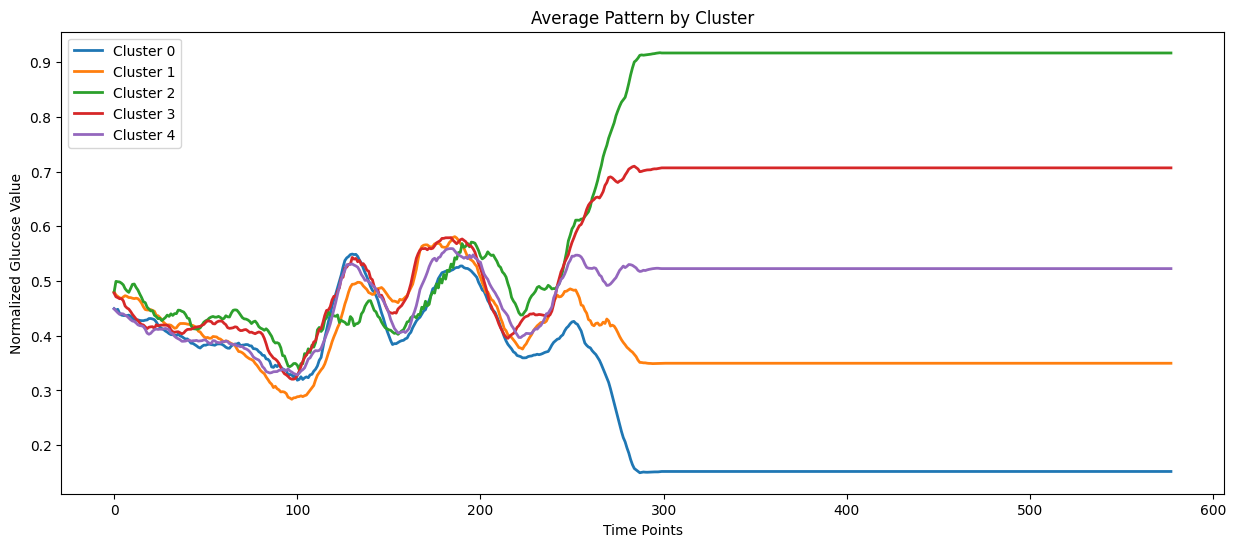

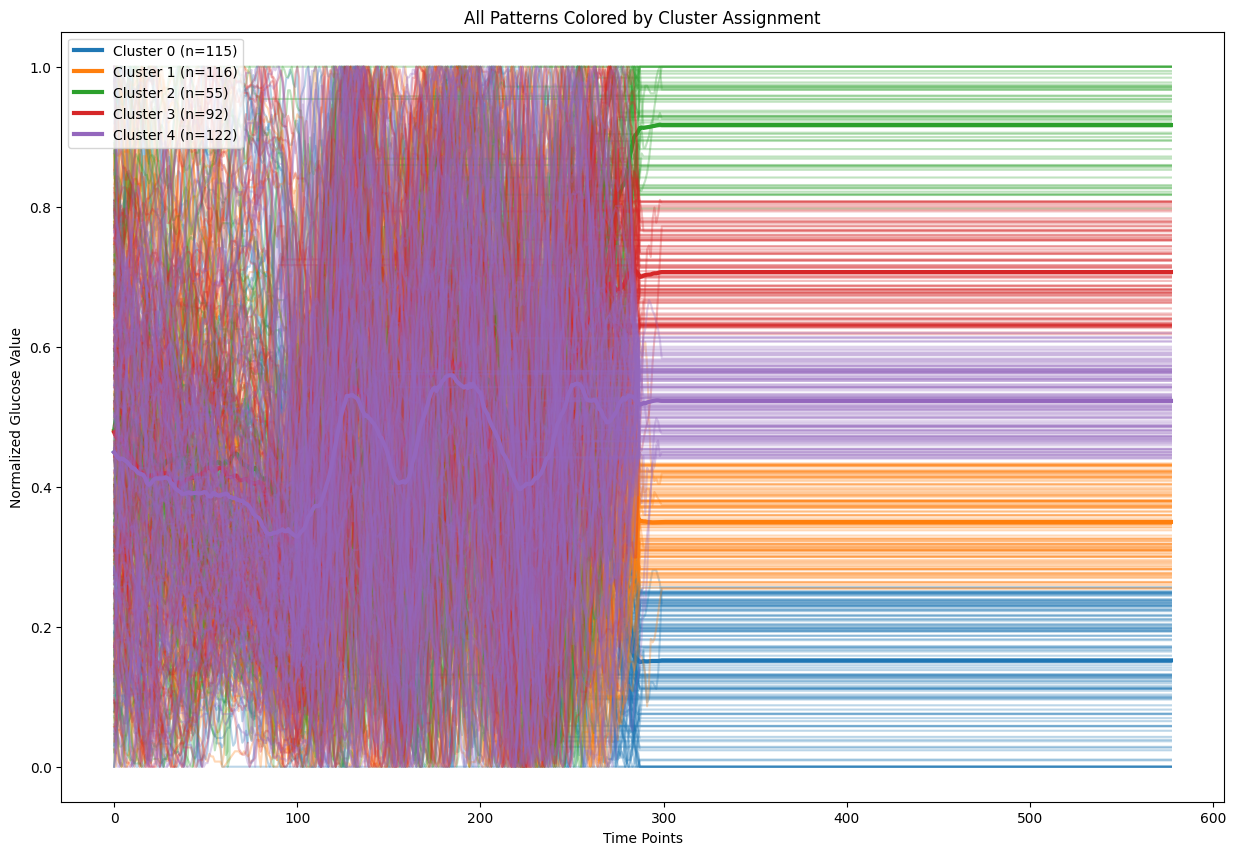

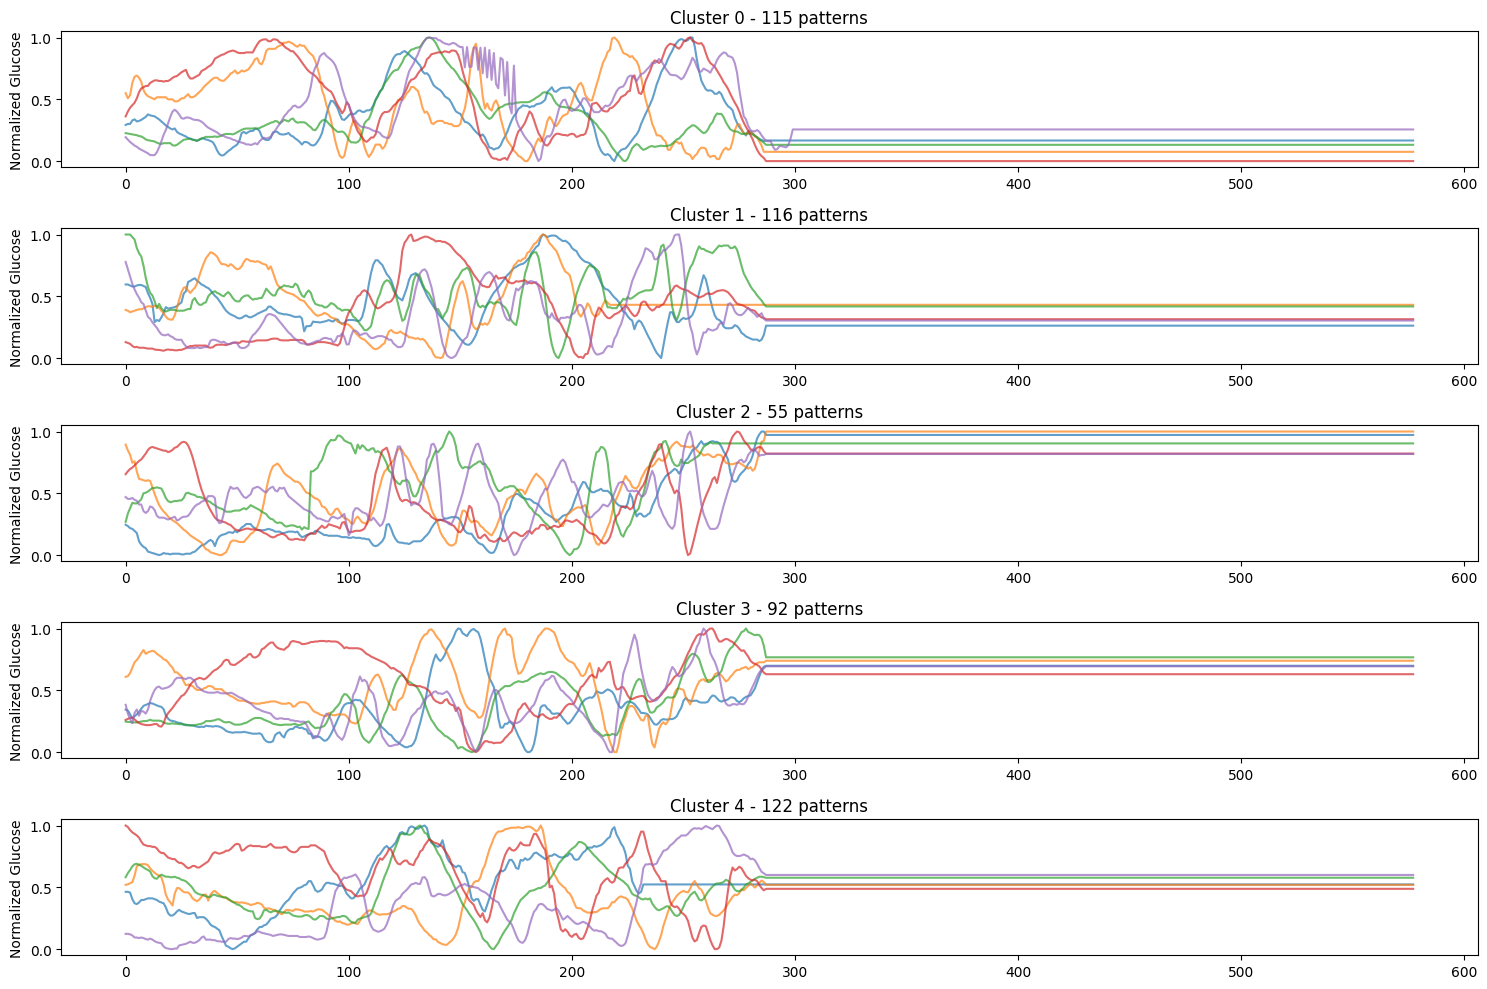

In [60]:
# 1. Plot average pattern for each cluster
plt.figure(figsize=(15, 6))
for i in range(kmeans.n_clusters):
    # Get all samples in this cluster
    cluster_samples = normalized_data_week[clusters == i]
    
    # Calculate mean pattern
    mean_pattern = np.mean(cluster_samples, axis=0)
    
    # Plot mean pattern
    plt.plot(mean_pattern, label=f'Cluster {i}', linewidth=2)

plt.title('Average Pattern by Cluster')
plt.xlabel('Time Points')
plt.ylabel('Normalized Glucose Value')
plt.legend()
plt.show()

# 3. Optional: Plot a few random examples from each cluster
plt.figure(figsize=(15, 10))
n_examples = 5  # number of examples to show from each cluster

for i in range(kmeans.n_clusters):
    plt.subplot(kmeans.n_clusters, 1, i+1)
    
    # Get samples in this cluster
    cluster_samples = normalized_data_week[clusters == i]
    
    # Randomly select n_examples
    if len(cluster_samples) > n_examples:
        random_indices = np.random.choice(len(cluster_samples), n_examples, replace=False)
        examples = cluster_samples[random_indices]
    else:
        examples = cluster_samples
    
    # Plot examples
    for sample in examples:
        plt.plot(sample, alpha=0.7)
    
    plt.title(f'Cluster {i} - {len(cluster_samples)} patterns')
    plt.ylabel('Normalized Glucose')

plt.tight_layout()
plt.show()

In [59]:
reshaped_data = sampled_data.reshape(sampled_data.shape[0], -1)

# Calculate silhouette score
score = silhouette_score(reshaped_data, clusters)
print(f'Silhouette Score: {score}')


Silhouette Score: 0.09009170866107254
